In [69]:
# Pres play do imports

import pandas as pd
import os
import sys
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Tab, Output

# Add the project folder to sys.path
sys.path.append(r'C:\StockAnalyticsProject')
from MyTools.ApiClient import ApiClient
api_client = ApiClient()

dataFolderPath = './'
portfolioFolderPath = os.path.join(dataFolderPath,'etf_portfolio')
portfolioFilePath = os.path.join(portfolioFolderPath, 'portfolio.csv')

risk_free_rate = 0.01


In [67]:
#first data import
codeDB, db=api_client.get('getRows',{"assetType": "INDEX"})
if codeDB != 0:
    print(f"Error fetching data: {db}")
else:
    db=pd.DataFrame(db)
    db_index = db[db['assetType'] == 'INDEX']
    print(db_index[['Name']])

Calling http://vaio/getRows with params: {'assetType': 'INDEX'}
Error fetching data: The request timed out


Define the the stock to analyze and the comparison indexes

^IRX will always be included for risk free

In [70]:
# Show form to select stock and indexes
default_markets = ['^NDX','^GSPC','^DJI','^RUT','^FTSE','^GDAXI','^FCHI','^STOXX50E']
try:
    if 'db_index' in globals() and not db_index.empty and 'Symbol' in db_index.columns:
        market_choices = sorted(set(db_index['Symbol']).intersection(default_markets)) or default_markets
    else:
        market_choices = default_markets
except Exception:
    market_choices = default_markets

risk_free_symbol = '^IRX'
other_candidates = [s for s in market_choices if s != risk_free_symbol]

# Widgets
w_stock = widgets.Text(
    value=globals().get('stockSymbol','BE'),
    description='Stock:',
    layout=widgets.Layout(width='200px')
)

w_market = widgets.Dropdown(
    options=market_choices,
    value=globals().get('market','^NDX') if globals().get('market','^NDX') in market_choices else market_choices[0],
    description='Market:',
    layout=widgets.Layout(width='200px')
)

# Pre-select previously set othersList if possible
prev_others = [o for o in globals().get('othersList', ['^RUT']) if o in other_candidates and o != w_market.value]
if not prev_others:
    prev_others = ['^RUT'] if '^RUT' in other_candidates and '^RUT' != w_market.value else []

w_others = widgets.SelectMultiple(
    options=other_candidates,
    value=tuple(prev_others),
    description='Others:',
    rows=6,
    layout=widgets.Layout(width='220px')
)

apply_button = widgets.Button(
    description='Apply',
    button_style='primary',
    icon='check'
)

out_form = widgets.Output()

def on_market_change(change):
    # Ensure market not in others
    if change['name'] == 'value' and change['new']:
        current_market = change['new']
        w_others.options = [s for s in other_candidates if s != current_market]

w_market.observe(on_market_change)

def apply_settings(_):
    with out_form:
        clear_output()
        # Update globals so downstream cells use them
        globals()['stockSymbol'] = w_stock.value.strip()
        globals()['market'] = w_market.value
        globals()['othersList'] = [s for s in w_others.value if s != w_market.value]
        print("Selections applied:")
        print(f"stockSymbol = {stockSymbol}")
        print(f"market = {market}")
        print(f"othersList = {othersList}")
        if not othersList:
            print("Note: othersList is empty. You can select comparison indexes in the list.")
        print("Run the subsequent cells to refresh the analysis.")

apply_button.on_click(apply_settings)

form = widgets.VBox([
    widgets.HBox([w_stock, w_market]),
    w_others,
    apply_button,
    out_form
])

display(form)

In [ ]:
code, stockData=api_client.get('getRows',{"Symbols": stockSymbol})
stockData=pd.DataFrame(stockData).to_dict(orient='records')[0]
stockData

In [9]:
## não terminadoo. o Index está cheio de lixo e não tem o return que interessa

code, sector_historic = api_client.get("getIndex", {"region":stockData['myRegion'],"sectorKey": stockData['sectorKey']})
sector_historic=pd.DataFrame(sector_historic)
sector_historic = sector_historic.rename(columns={f"{stockData['myRegion']}sector-return": 'rs'})


Calling http://vaio/getIndex with params: {'region': 'USD', 'sectorKey': 'industrials'}


ValueError: DataFrame constructor not properly called!

In [8]:
sector_historic

'The request timed out'

In [34]:
code, symbol_historic = api_client.get("getHistory", {"tickerSymbol": stockSymbol})
symbol_historic = pd.DataFrame(symbol_historic)

history_df = pd.DataFrame({'Date': symbol_historic['Date'], 'Close': symbol_historic['Close'],'volume': symbol_historic['Volume']})
history_df['Date'] = pd.to_datetime(history_df['Date'], unit='ms').dt.strftime('%Y-%m-%d')
earliest_date = history_df['Date'].min()
print(f"Earliest Date for {stockSymbol}: {earliest_date}")
history_df['r'] = history_df['Close'].pct_change()
history_df['r'] = history_df['r'].fillna(0)
history_df = history_df.drop(columns=['Close'])

code, symbol_historic = api_client.get("getHistory", {"tickerSymbol": '^IRX'})
symbol_historic = pd.DataFrame({'Date': symbol_historic['Date'], 'Close': symbol_historic['Close']})
symbol_historic['Date'] = pd.to_datetime(symbol_historic['Date'], unit='ms').dt.strftime('%Y-%m-%d')
print(f"Earliest Date for IRX: {symbol_historic['Date'].min()}")
if symbol_historic['Date'].min() > earliest_date:
    earliest_date = symbol_historic['Date'].min()
symbol_historic['rf'] = symbol_historic['Close'].pct_change()
history_df['r'] = history_df['r'].fillna(0)
symbol_historic = symbol_historic.drop(columns=['Close'])
history_df = pd.merge(history_df, symbol_historic, on='Date', how='outer')

code, symbol_historic = api_client.get("getHistory", {"tickerSymbol": market})
symbol_hist_df = pd.DataFrame({'Date': symbol_historic['Date'], 'Close': symbol_historic['Close']})
symbol_hist_df['Date'] = pd.to_datetime(symbol_hist_df['Date'], unit='ms').dt.strftime('%Y-%m-%d')
print(f"Earliest Date for market: {symbol_hist_df['Date'].min()}")
if symbol_hist_df['Date'].min() > earliest_date:
    earliest_date = symbol_hist_df['Date'].min()
symbol_hist_df['r'] = symbol_hist_df['Close'].pct_change()
symbol_hist_df['rm'] = symbol_hist_df['r'].fillna(0)
symbol_hist_df = symbol_hist_df.drop(columns=['Close','r'])
history_df = pd.merge(history_df, symbol_hist_df, on='Date', how='outer')



for symbol in othersList:
    try:
        code, symbol_historic = api_client.get("getHistory", {"tickerSymbol": symbol})
        symbol_hist_df = pd.DataFrame({'Date': symbol_historic['Date'], 'Close': symbol_historic['Close']})
        symbol_hist_df['Date'] = pd.to_datetime(symbol_hist_df['Date'], unit='ms').dt.strftime('%Y-%m-%d')
        print(f"Earliest Date: {symbol_hist_df['Date'].min()}")
        if symbol_hist_df['Date'].min() > earliest_date:
            earliest_date = symbol_hist_df['Date'].min()
        symbol_hist_df['r'] = symbol_hist_df['Close'].pct_change()
        symbol_hist_df[f'r-{symbol}'] = symbol_hist_df['r'].fillna(0)
        symbol_hist_df = symbol_hist_df.drop(columns=['Close','r'])
        history_df = pd.merge(history_df, symbol_hist_df, on='Date', how='outer')
    except Exception as e:
        print(f"Error processing symbol {symbol}: {e}")

history_df['rf'] = history_df['rf'].ffill()
print(f"Earliest Date: {earliest_date}")
history_df = history_df[history_df['Date'] >= earliest_date]

history_df['excess-r'] = history_df['r'] - history_df['rf']
history_df['excess-rm'] = history_df['rm'] - history_df['rf']

Calling http://vaio/getHistory with params: {'tickerSymbol': 'BE'}
Earliest Date for BE: 2018-07-25
Calling http://vaio/getHistory with params: {'tickerSymbol': '^IRX'}
Earliest Date for IRX: 1960-01-04
Calling http://vaio/getHistory with params: {'tickerSymbol': '^NDX'}
Earliest Date for market: 1985-10-01
Calling http://vaio/getHistory with params: {'tickerSymbol': '^RUT'}
Earliest Date: 1987-09-10
Earliest Date: 2018-07-25


In [18]:
## não terminadoo. o Index está cheio de lixo e não tem o return que interessa

code, sector_historic = api_client.get("getIndex", {"region":stockData['myRegion'],"sectorKey": stockData['sectorKey']})
sector_historic=pd.DataFrame(sector_historic)

Calling http://vaio/getIndex with params: {'region': 'USD', 'sectorKey': 'consumer-defensive'}


The data is now prepared. Only the rows with valid stock returns have been kept.

In [35]:
history_df

,Date,volume,r,rf,rm,r-^RUT,excess-r,excess-rm
14688,2018-07-25,13709500.0,0.000000,-0.003571,0.013818,0.002976,0.003571,0.017390
14689,2018-07-26,3628300.0,-0.159600,-0.004096,-0.014362,0.006029,-0.155504,-0.010266
14690,2018-07-27,1320700.0,0.075678,0.000000,-0.014049,-0.018887,0.075678,-0.014049
14691,2018-07-30,1236300.0,0.055310,0.000000,-0.014209,-0.006138,0.055310,-0.014209
14692,2018-07-31,2603400.0,-0.033543,0.020566,0.005405,0.010689,-0.054109,-0.015160
...,...,...,...,...,...,...,...,...
16454,2025-08-05,11714400.0,0.041828,-0.000722,-0.007333,0.006042,0.042551,-0.006611
16455,2025-08-06,8640802.0,0.033236,-0.004096,0.012880,-0.001970,0.037332,0.016976
16456,2025-08-07,9586800.0,-0.053011,0.001210,0.003195,-0.002956,-0.054221,0.001985
16457,2025-08-08,4753500.0,0.000000,-0.001208,0.009480,0.001671,0.001208,0.010689


Next, let's compute CAPM metrics ofr all the available historic:
- excess returns
- excess market returns
- Beta correlation
- Alfa

In [40]:


# Drop NA values for regression
capm_df = history_df[['excess-r', 'excess-rm']].dropna()
X = capm_df['excess-rm'].values.reshape(-1, 1)
y = capm_df['excess-r'].values
model = LinearRegression().fit(X, y)
beta = model.coef_[0]
alfa = model.intercept_

print(f"Summary data for {stockSymbol} - {stockData['Name']} from {earliest_date} to {history_df['Date'].max()}\n")
print(f"Beta: {beta:.2f}")
print(f"Alfa (annual): {(alfa*np.sqrt(252)):.4%}")
print(f"Daily Volatility {stockSymbol}: {history_df['r'].std():.2%}")
print(f"Daily Volatility ({market}): {history_df['rm'].std():.2%}")
print(f"Sharpe Ratio {stockSymbol}: {(history_df['excess-r'].mean() / history_df['excess-r'].std()):.2f}")
print(f"Sharpe Ratio ({market}): {(history_df['excess-rm'].mean() / history_df['excess-rm'].std()):.2f}")

Summary data for BE - Bloom Energy Corporation from 2018-07-25 to 2025-08-11

Beta: 1.03
Alfa (annual): 1.8536%
Daily Volatility BE: 5.85%
Daily Volatility (^NDX): 1.58%
Sharpe Ratio BE: -0.00
Sharpe Ratio (^NDX): -0.01


A partir de agora focamos a análise nos últimos dois anos

Primeiro definir algumas variáveis

In [61]:
lookback_days = 2 * 365
base_figsize = (10, 5)
scale = 1.5  # default fallback if not previously defined

Now, let's create a lookbak dataframe containing just the short term time span to focus analysis

And calculate the metrics

In [60]:
lookback = (datetime.now() - timedelta(days=lookback_days)).strftime('%Y-%m-%d')
lookback_df = history_df[history_df['Date'] >= lookback].copy()

# Build base-100 cumulative indexes for r, rm
cols = ['r', 'rm']
for c in cols:
    lookback_df[c + '_idx'] = 100 * (1 + lookback_df[c]).cumprod()
    #create EMA 30 and 90
    lookback_df[c + '_ema20'] = lookback_df[c + '_idx'].ewm(span=30, adjust=False).mean()
    lookback_df[c + '_ema90'] = lookback_df[c + '_idx'].ewm(span=90, adjust=False).mean()

#create keltner channel for r_idx
lookback_df['r_idx_kc_upper'] = lookback_df['r_idx'].ewm(span=20, adjust=False).mean() + 2 * lookback_df['r_idx'].ewm(span=20, adjust=False).std()
lookback_df['r_idx_kc_lower'] = lookback_df['r_idx'].ewm(span=20, adjust=False).mean() - 2 * lookback_df['r_idx'].ewm(span=20, adjust=False).std()
#bollinger bands
lookback_df['r_idx_bb_upper'] = lookback_df['r_idx'].rolling(window=20).mean() + 2 * lookback_df['r_idx'].rolling(window=20).std()
lookback_df['r_idx_bb_lower'] = lookback_df['r_idx'].rolling(window=20).mean() - 2 * lookback_df['r_idx'].rolling(window=20).std()

In [ ]:
dates = pd.to_datetime(lookback_df['Date'])

plt.figure(figsize=(base_figsize[0] * scale, base_figsize[1] * scale))
for c in cols:
    # main indexed performance (thinner)
    plt.plot(dates, lookback_df[c + '_idx'], label=f'{c} idx', linewidth=1.1)
    # EMAs on indexed performance
    plt.plot(dates, lookback_df[c + '_ema30'], label=f'{c} EMA30', linestyle='--', linewidth=0.9)
    plt.plot(dates, lookback_df[c + '_ema90'], label=f'{c} EMA90', linestyle=':', linewidth=0.9)

plt.title(f'Indexed performance (base=100) - {stockSymbol} vs {market} (last 2 years)')
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

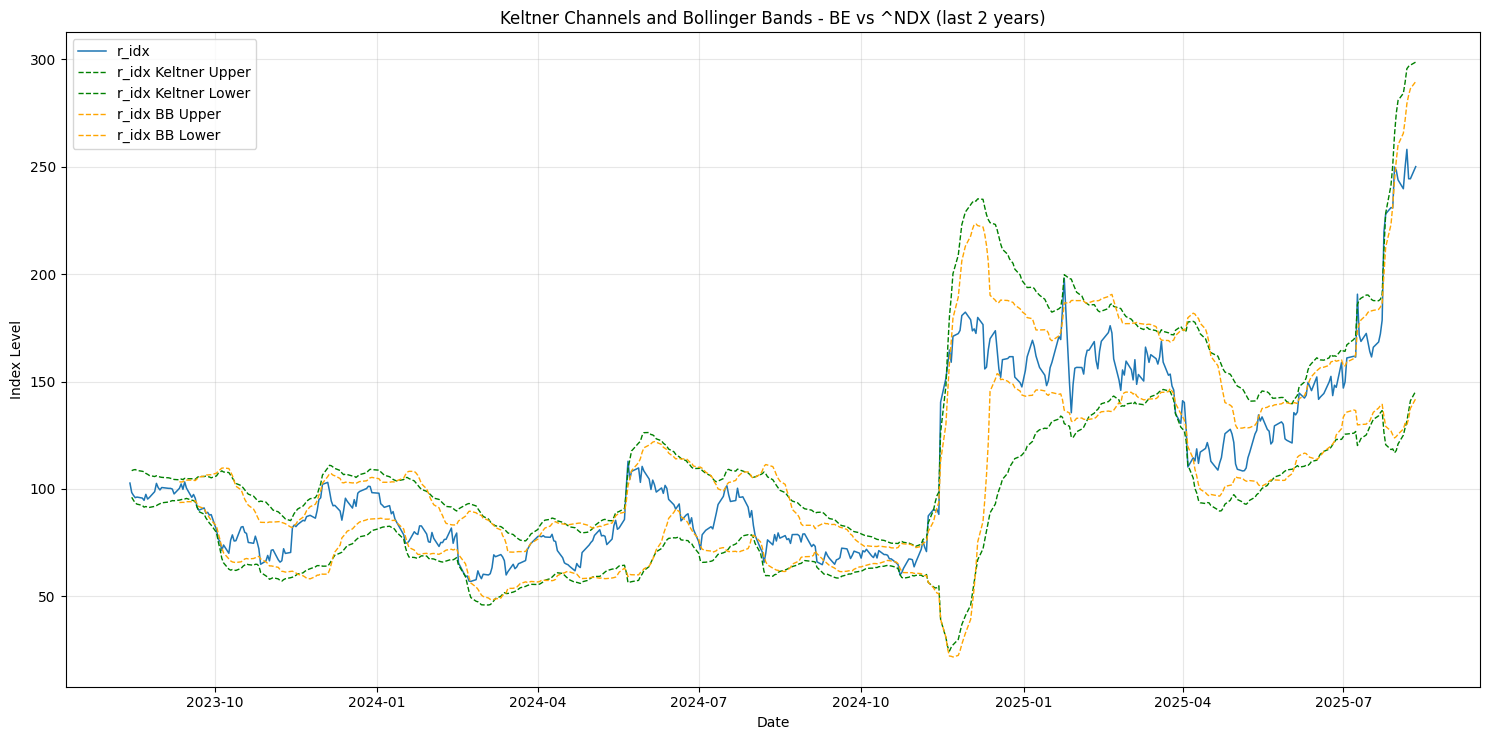

In [62]:
plt.figure(figsize=(base_figsize[0] * scale, base_figsize[1] * scale))
plt.plot(dates, lookback_df['r_idx'], label='r_idx', linewidth=1.1)
plt.plot(dates, lookback_df['r_idx_kc_upper'], label='r_idx Keltner Upper', linestyle='--', linewidth=1, color='green')
plt.plot(dates, lookback_df['r_idx_kc_lower'], label='r_idx Keltner Lower', linestyle='--', linewidth=1, color='green')
plt.plot(dates, lookback_df['r_idx_bb_upper'], label='r_idx BB Upper', linestyle='--', linewidth=1, color='orange')
plt.plot(dates, lookback_df['r_idx_bb_lower'], label='r_idx BB Lower', linestyle='--', linewidth=1, color='orange')
plt.title(f'Keltner Channels and Bollinger Bands - {stockSymbol} vs {market} (last 2 years)')
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

Interactive tabbed view (requires ipywidgets). Run: pip install ipywidgets if not present.

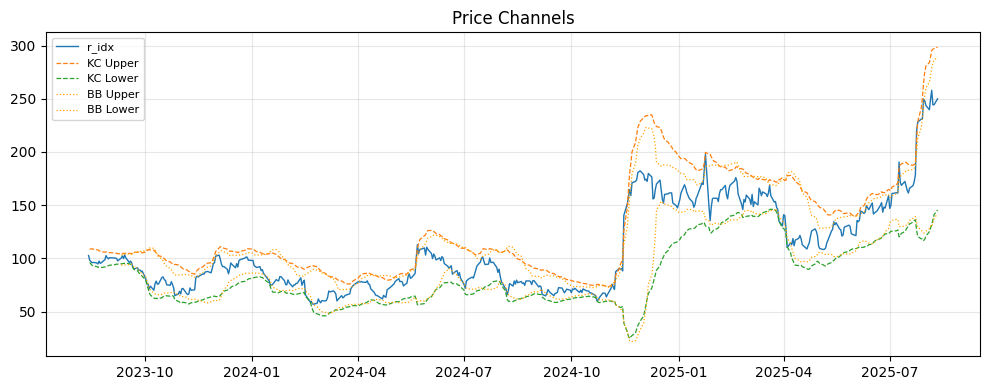

In [ ]:
out_overview = Output()
out_capm = Output()
out_lookback = Output()
out_channels = Output()

with out_overview:
    print('History (head):')
    display(history_df.head())
    print(f'Total rows: {len(history_df)}')

with out_capm:
    print('CAPM Metrics:')
    print(f'Beta: {beta:.2f}')
    print(f'Alfa (annual): {(alfa*np.sqrt(252)):.4%}')
    print(f'Daily Volatility {stockSymbol}: {history_df['r'].std():.2%}')
    print(f'Daily Volatility ({market}): {history_df['rm'].std():.2%}')
    print(f'Sharpe Ratio {stockSymbol}: {(history_df['excess-r'].mean() / history_df['excess-r'].std()):.2f}')
    print(f'Sharpe Ratio ({market}): {(history_df['excess-rm'].mean() / history_df['excess-rm'].std()):.2f}')

with out_lookback:
    print('Lookback (tail):')
    display(lookback_df.tail())
    print(f'Lookback rows: {len(lookback_df)}')

with out_channels:
    print('Channels Plot:')
    fig, ax = plt.subplots(figsize=(10,4))
    dt = pd.to_datetime(lookback_df['Date'])
    ax.plot(dt, lookback_df['r_idx'], label='r_idx', linewidth=1)
    ax.plot(dt, lookback_df['r_idx_kc_upper'], '--', label='KC Upper', linewidth=0.9)
    ax.plot(dt, lookback_df['r_idx_kc_lower'], '--', label='KC Lower', linewidth=0.9)
    ax.plot(dt, lookback_df['r_idx_bb_upper'], ':', label='BB Upper', linewidth=0.9, color='orange')
    ax.plot(dt, lookback_df['r_idx_bb_lower'], ':', label='BB Lower', linewidth=0.9, color='orange')
    ax.set_title('Price Channels')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)
    plt.tight_layout()

tabs = Tab(children=[out_overview, out_capm, out_lookback, out_channels])
for i, title in enumerate(['Overview','CAPM','Lookback','Channels']):
    tabs.set_title(i, title)
display(tabs)